In [1]:
%%capture state

from __future__ import division
from __future__ import print_function

import sys, os
sys.path.append('../')

import tensorflow as tf
import numpy as np

from models.neural_network import NeuralNetwork
from models.cnn import CNN

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

#Seed used for all calculations of training and test point indices 
SEED = 14

In [2]:
## Visualization of samples
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

def visualize(image):
    plt.figure(figsize=(1, 1))
    if image.shape[-1] == 1:
        # image is in black and white
        image = image[:, :, 0]
        plt.imshow(image, cmap='Greys')
    else:
        # image is in color
        plt.imshow(image)
    plt.axis('off')
    plt.show()

#Normalize rows of a given matrix
def normalize(matrix):
    matrix_nm = np.zeros_like(matrix)
    for i in range(matrix.shape[0]):
        matrix_nm[i] = matrix[i]/np.linalg.norm(matrix[i]) 
    return matrix_nm

In [3]:
#Load model from disk
model_name = 'MNIST-Pool'
model_save_path = '../trained_models/' + model_name + '-model.json'
weights_save_path = '../trained_models/' + model_name + 'weights'
model = CNN(model_name=model_name, dataset='mnist_pool')
epochs = 10
model.train(epochs=epochs)
model.save_model(model_save_path, weights_save_path)    

Train on 60000 samples, validate on 5000 samples
Epoch 1/10
60000/60000 [==============================] - 4s 70us/step - loss: 0.4476 - acc: 0.8573 - val_loss: 0.0973 - val_acc: 0.9730
Epoch 2/10
60000/60000 [==============================] - 3s 43us/step - loss: 0.1599 - acc: 0.9528 - val_loss: 0.0624 - val_acc: 0.9796
Epoch 3/10
60000/60000 [==============================] - 3s 43us/step - loss: 0.1216 - acc: 0.9637 - val_loss: 0.0502 - val_acc: 0.9842
Epoch 4/10
60000/60000 [==============================] - 3s 43us/step - loss: 0.1000 - acc: 0.9695 - val_loss: 0.0443 - val_acc: 0.9854
Epoch 5/10
60000/60000 [==============================] - 3s 43us/step - loss: 0.0900 - acc: 0.9734 - val_loss: 0.0405 - val_acc: 0.9868
Epoch 6/10
60000/60000 [==============================] - 3s 43us/step - loss: 0.0780 - acc: 0.9760 - val_loss: 0.0347 - val_acc: 0.9898
Epoch 7/10
60000/60000 [==============================] - 3s 43us/step - loss: 0.0700 - acc: 0.9788 - val_loss: 0.0358 - val_acc:

In [4]:
#Get training samples
num_train_samples = 10000
data_indices = model.gen_rand_indices(low=0, high=model.train_data.shape[0], seed=SEED, num_samples=num_train_samples)
train_data = model.train_data[data_indices]
train_data_labels = model.train_labels[data_indices]
train_data_labels_int = np.argmax(train_data_labels, axis=1)

In [5]:
num_test_samples_per_class = 100
num_test_samples = 10*num_test_samples_per_class

#Generate test points
test_indices = model.gen_rand_indices_all_classes(y=model.test_labels, seed=SEED, num_samples=num_test_samples_per_class)

#Get Regular, Noisy, FGSM, BIM, and CW test points
reg_data = model.test_data[test_indices]
noisy_data = model.generate_perturbed_data(model.test_data[test_indices], model.test_labels[test_indices],seed=SEED, perturbation='Noisy')
fgsm_data = model.generate_perturbed_data(model.test_data[test_indices], model.test_labels[test_indices],seed=SEED, perturbation='FGSM')
bim_data = model.generate_perturbed_data(model.test_data[test_indices], model.test_labels[test_indices], seed=SEED, perturbation='BIM', iterations=10)
cw_data = model.generate_perturbed_data(model.test_data[test_indices], model.test_labels[test_indices],seed=SEED, perturbation='CW', targeted=False)

/root/notebook/cleverhans/cleverhans/src/cleverhans/cleverhans/utils_keras.py:144: UserWarning: Please update your version to keras >= 2.1.3; support for earlier keras versions will be dropped on 2018-07-22
  "Please update your version to keras >= 2.1.3; "


In [6]:
#Reset tf.graph() as Cleverhans modifies the graph
tf.reset_default_graph()

#Reload the model and weights
model = CNN(model_name=model_name,dataset='mnist_pool')
model.load_model(model_save_path, weights_save_path)    

Loaded model from disk


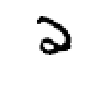

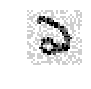

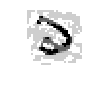

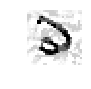

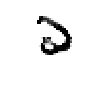

In [7]:
#Lets visualize one sample from each dataset
x_vis = np.random.choice(range(0,num_test_samples), 1)
visualize(reg_data[x_vis].reshape(28,28,1))
visualize(noisy_data[x_vis].reshape(28,28,1))
visualize(fgsm_data[x_vis].reshape(28,28,1))
visualize(bim_data[x_vis].reshape(28,28,1))
visualize(cw_data[x_vis].reshape(28,28,1))

In [8]:
#Get predictions
reg_preds = model.model.predict(reg_data.reshape(-1,28,28,1))
noisy_preds = model.model.predict(noisy_data.reshape(-1,28,28,1))
fgsm_preds = model.model.predict(fgsm_data.reshape(-1,28,28,1))
bim_preds = model.model.predict(bim_data.reshape(-1,28,28,1))
cw_preds = model.model.predict(cw_data.reshape(-1,28,28,1))

In [9]:
#Convert preds to labels
reg_labels = np.zeros(reg_preds.shape)
reg_labels[np.arange(num_test_samples),np.argmax(reg_preds, axis=1)] = 1

noisy_labels = np.zeros(noisy_preds.shape)
noisy_labels[np.arange(num_test_samples),np.argmax(noisy_preds, axis=1)] = 1

fgsm_labels = np.zeros(fgsm_preds.shape)
fgsm_labels[np.arange(num_test_samples),np.argmax(fgsm_preds, axis=1)] = 1

bim_labels = np.zeros(bim_preds.shape)
bim_labels[np.arange(num_test_samples),np.argmax(bim_preds, axis=1)] = 1

cw_labels = np.zeros(cw_preds.shape)
cw_labels[np.arange(num_test_samples),np.argmax(cw_preds, axis=1)] = 1


In [10]:
#Check preds to ensure adversarial samples were generated correctly
print (np.argmax(reg_preds, axis=1))
print (np.argmax(noisy_preds, axis=1))
print (np.argmax(fgsm_preds, axis=1))
print (np.argmax(bim_preds, axis=1))
print (np.argmax(cw_preds, axis=1))


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1
 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2
 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 8 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 

In [11]:
#Get gradients for all test points
grads_reg = model.get_gradients_wrt_params(reg_data, reg_labels)
grads_noisy = model.get_gradients_wrt_params(noisy_data, noisy_labels)
grads_fgsm = model.get_gradients_wrt_params(fgsm_data, fgsm_labels)
grads_bim = model.get_gradients_wrt_params(bim_data, bim_labels)
grads_cw = model.get_gradients_wrt_params(cw_data, cw_labels)


#Get gradients for training points 
grads_train = model.get_gradients_wrt_params(train_data, train_data_labels)

In [12]:
grads_reg_nm = normalize(grads_reg)
grads_noisy_nm = normalize(grads_noisy)
grads_fgsm_nm = normalize(grads_fgsm)
grads_bim_nm = normalize(grads_bim)
grads_cw_nm = normalize(grads_cw)

grads_train_nm = normalize(grads_train)

In [13]:
#Get norms 
grads_reg_norms = np.sqrt(np.dot(grads_reg, grads_reg.T)).diagonal()
grads_noisy_norms = np.sqrt(np.dot(grads_noisy, grads_noisy.T)).diagonal()
grads_bim_norms = np.sqrt(np.dot(grads_bim, grads_bim.T)).diagonal()
grads_fgsm_norms = np.sqrt(np.dot(grads_fgsm, grads_fgsm.T)).diagonal()
grads_cw_norms = np.sqrt(np.dot(grads_cw, grads_cw.T)).diagonal()


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in sqrt
  after removing the cwd from sys.path.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in sqrt
  


In [14]:
#Get cosine similarity matrix
cos_sim_reg = np.dot(grads_reg_nm, grads_train_nm.T)
cos_sim_noisy = np.dot(grads_noisy_nm, grads_train_nm.T)
cos_sim_fgsm = np.dot(grads_fgsm_nm, grads_train_nm.T)
cos_sim_bim = np.dot(grads_bim_nm, grads_train_nm.T)
cos_sim_cw = np.dot(grads_cw_nm, grads_train_nm.T)


In [24]:
#Separate Using Cos Sim

eta = 0.81

count = 0.0
for i in range(num_test_samples):
    if np.max(cos_sim_reg[i]) > eta:
        count+=1.0
        
print ('Regular: %.4f' % ( count/num_test_samples))

count = 0.0
for i in range(num_test_samples):
    if np.max(cos_sim_noisy[i]) > eta:
        count+=1.0
    
print ('Noisy:  %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_fgsm[i]) > eta:
        count+=1.0
        
print ('FGSM:  %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_bim[i]) > eta:
        count+=1.0
        
print ('BIM:  %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_cw[i]) > eta:
        count+=1.0
    
print ('CW: %.4f' % ( count/num_test_samples))



Regular: 0.8590
Noisy:  0.3900
FGSM:  0.2400
BIM:  0.4230
CW: 0.0810


In [22]:
#Separate using just norm
gamma = 0.15

count = 0.0
for i in range(num_test_samples):
    if grads_reg_norms[i] < gamma:
        count+=1.0
        
print ('Regular: %.4f' % ( count/num_test_samples))

count = 0.0
for i in range(num_test_samples):
    if grads_noisy_norms[i] < gamma:
        count+=1.0
    
print ('Noisy:  %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if grads_fgsm_norms[i] < gamma:
        count+=1.0
        
print ('FGSM:  %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if grads_bim_norms[i] < gamma:
        count+=1.0
        
print ('BIM:  %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if grads_cw_norms[i] < gamma:
        count+=1.0
    
print ('CW: %.4f' % ( count/num_test_samples))




Regular: 0.8640
Noisy:  0.1280
FGSM:  0.0170
BIM:  0.3850
CW: 0.0000


In [25]:
#Use both

count = 0.0
for i in range(num_test_samples):
    if np.max(cos_sim_reg[i]) > eta and grads_reg_norms[i] < gamma:
        count+=1.0
        
print ('Regular: %.4f' % ( count/num_test_samples))

count = 0.0
for i in range(num_test_samples):
    if np.max(cos_sim_noisy[i]) > eta and grads_noisy_norms[i] < gamma:
        count+=1.0
    
print ('Noisy:  %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_fgsm[i]) > eta and grads_fgsm_norms[i] < gamma:
        count+=1.0
        
print ('FGSM:  %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_bim[i]) > eta and grads_bim_norms[i] < gamma:
        count+=1.0
        
print ('BIM:  %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_cw[i]) > eta and grads_cw_norms[i] < gamma:
        count+=1.0
    
print ('CW: %.4f' % ( count/num_test_samples))





Regular: 0.7960
Noisy:  0.0970
FGSM:  0.0100
BIM:  0.2540
CW: 0.0000


In [16]:
"""#Create training data with first 450 points of each class, with first 50 scores
x = np.zeros((6000, 4))
y = np.zeros((6000, 1))

for i in range(1000):
        reg_dis = cos_sim_reg[i][np.where( train_data_1k_labels_int == np.argmax(reg_preds[i]))[0]]
        noisy_dis = cos_sim_noisy[i][np.where( train_data_1k_labels_int == np.argmax(noisy_preds[i]))[0]]
        fgsm_dis = cos_sim_fgsm[i][np.where( train_data_1k_labels_int == np.argmax(fgsm_preds[i]))[0]]
        bim_dis = cos_sim_bim[i][np.where( train_data_1k_labels_int == np.argmax(bim_preds[i]))[0]]
        cw_dis = cos_sim_cw[i][np.where( train_data_1k_labels_int == np.argmax(cw_preds[i]))[0]]
        mod_cw_dis = cos_sim_mod_cw[i][np.where( train_data_1k_labels_int == np.argmax(mod_cw_preds[i]))[0]]
        x[i*6] = np.array([np.median(reg_dis), np.max(reg_dis), np.min(reg_dis), np.var(reg_dis)])
        y[i*6] = 0
        x[i*6 + 1] = np.array([np.median(noisy_dis), np.max(noisy_dis), np.min(noisy_dis), np.var(noisy_dis)])
        y[i*6 + 1] = 0
        x[i*6 + 2] = np.array([np.median(fgsm_dis), np.max(fgsm_dis), np.min(fgsm_dis), np.var(fgsm_dis)])
        y[i*6 + 2] = 1
        x[i*6+3] = np.array([np.median(bim_dis), np.max(bim_dis), np.min(bim_dis), np.var(bim_dis)])
        y[i*6+3] = 1
        x[i*6+4] = np.array([np.median(cw_dis), np.max(cw_dis), np.min(cw_dis), np.var(cw_dis)])
        y[i*6+4] = 1
        x[i*6+5] = np.array([np.median(mod_cw_dis), np.max(mod_cw_dis), np.min(mod_cw_dis), np.var(mod_cw_dis)])
        y[i*6+5] = 1
x_train = x[:5700]
y_train = y[:5700]
x_test = x[5700:]
y_test = y[5700:]
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(solver='newton-cg', max_iter=10000).fit(x_train, y_train)

#Plot ROC 
preds = clf.predict_proba(x_test)
preds_bad = preds[:,1]
from sklearn import metrics 
fpr, tpr, thresholds = metrics.roc_curve(y_test, preds_bad, pos_label=1)
plt.plot(fpr,tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show() 
"""

"#Create training data with first 450 points of each class, with first 50 scores\nx = np.zeros((6000, 4))\ny = np.zeros((6000, 1))\n\nfor i in range(1000):\n        reg_dis = cos_sim_reg[i][np.where( train_data_1k_labels_int == np.argmax(reg_preds[i]))[0]]\n        noisy_dis = cos_sim_noisy[i][np.where( train_data_1k_labels_int == np.argmax(noisy_preds[i]))[0]]\n        fgsm_dis = cos_sim_fgsm[i][np.where( train_data_1k_labels_int == np.argmax(fgsm_preds[i]))[0]]\n        bim_dis = cos_sim_bim[i][np.where( train_data_1k_labels_int == np.argmax(bim_preds[i]))[0]]\n        cw_dis = cos_sim_cw[i][np.where( train_data_1k_labels_int == np.argmax(cw_preds[i]))[0]]\n        mod_cw_dis = cos_sim_mod_cw[i][np.where( train_data_1k_labels_int == np.argmax(mod_cw_preds[i]))[0]]\n        x[i*6] = np.array([np.median(reg_dis), np.max(reg_dis), np.min(reg_dis), np.var(reg_dis)])\n        y[i*6] = 0\n        x[i*6 + 1] = np.array([np.median(noisy_dis), np.max(noisy_dis), np.min(noisy_dis), np.var(nois